First I will load in the dataset

In [2]:
import pandas as pd

file = "steel.csv"
df = pd.read_csv(file)

df.head(), df.shape

(   normalising_temperature  tempering_temperature  percent_silicon  \
 0                  178.500                    275           0.1530   
 1                  178.500                    950           0.1530   
 2                  178.500                    375           0.1530   
 3                  178.500                    900           0.1530   
 4                  189.525                    900           0.1624   
 
    percent_chromium  percent_copper  percent_nickel  percent_sulphur  \
 0          0.970575           0.942          0.8870              0.0   
 1          1.212726           0.942          0.8870              0.0   
 2          1.621165           0.942          0.8870              0.0   
 3          0.809989           0.942          0.8870              0.0   
 4          1.036229           0.849          0.9382              0.0   
 
    percent_carbon  percent_manganese  tensile_strength  
 0           1.920                0.0         25.107613  
 1           1.9

In [3]:
# select independent and dependent variables
dependent_col = "tensile_strength"
independent_cols = [col for col in df.columns if col != dependent_col]

X = df[independent_cols]
y = df[dependent_col]

X.head(), y.head(), X.shape, y.shape

(   normalising_temperature  tempering_temperature  percent_silicon  \
 0                  178.500                    275           0.1530   
 1                  178.500                    950           0.1530   
 2                  178.500                    375           0.1530   
 3                  178.500                    900           0.1530   
 4                  189.525                    900           0.1624   
 
    percent_chromium  percent_copper  percent_nickel  percent_sulphur  \
 0          0.970575           0.942          0.8870              0.0   
 1          1.212726           0.942          0.8870              0.0   
 2          1.621165           0.942          0.8870              0.0   
 3          0.809989           0.942          0.8870              0.0   
 4          1.036229           0.849          0.9382              0.0   
 
    percent_carbon  percent_manganese  
 0           1.920                0.0  
 1           1.920                0.0  
 2          

I will preprocess my data using standard scaler as performance will be affected

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:5]

array([[-1.84808128, -1.8422778 ,  1.10582626, -1.18024956,  2.30540967,
        -1.1534779 , -1.07147549,  0.55514542, -0.92684122],
       [-1.84808128,  0.76403733,  1.10582626, -0.24905658,  2.30540967,
        -1.1534779 , -1.07147549,  0.55514542, -0.92684122],
       [-1.84808128, -1.45615704,  1.10582626,  1.32159528,  2.30540967,
        -1.1534779 , -1.07147549,  0.55514542, -0.92684122],
       [-1.84808128,  0.57097695,  1.10582626, -1.7977837 ,  2.30540967,
        -1.1534779 , -1.07147549,  0.55514542, -0.92684122],
       [-1.78009749,  0.57097695,  1.22247693, -0.9277751 ,  0.94827581,
        -0.46348087, -1.07147549,  1.17591397, -0.92684122]])

In [5]:
# set up evaluation metrics

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [6]:
# implementing 10 fold cross validation
from sklearn.model_selection import KFold

def evaluate_model(model,X,Y):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    rmse_list = []
    mae_list = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        rmse_list.append(rmse(y_test, y_pred))
        mae_list.append(mean_absolute_error(y_test, y_pred))
    
    avg_rmse = np.mean(rmse_list)
    avg_mae = np.mean(mae_list)
    
    return avg_rmse, avg_mae

Now I will setup the SVR model with the default hyperparameters

In [8]:
from sklearn.svm import SVR

svr_default = SVR() #  C=1.0, epsilon=0.1, kernel='rbf', gamma ='scale'

svr_rmse_default, svr_mae_default = evaluate_model(svr_default, X_scaled, y)

print(f"SVR Default - RMSE: {svr_rmse_default:.4f}, MAE: {svr_mae_default:.4f}")

SVR Default - RMSE: 78.6242, MAE: 62.5743


Now I will explore using different values of C and plotting the results

In [11]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

rmse_results = []
mae_results = []

for C in C_values:
    svr_model = SVR(C=C)
    rmse_val, mae_val = evaluate_model(svr_model, X_scaled, y)
    rmse_results.append(rmse_val)
    mae_results.append(mae_val)
    print(f"SVR with C={C} - RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")

SVR with C=0.001 - RMSE: 90.4941, MAE: 72.8188
SVR with C=0.01 - RMSE: 90.3659, MAE: 72.7025
SVR with C=0.1 - RMSE: 89.0920, MAE: 71.5499
SVR with C=1 - RMSE: 78.6242, MAE: 62.5743
SVR with C=10 - RMSE: 47.3060, MAE: 36.0899
SVR with C=100 - RMSE: 33.9351, MAE: 25.3145
SVR with C=1000 - RMSE: 30.5977, MAE: 22.1947


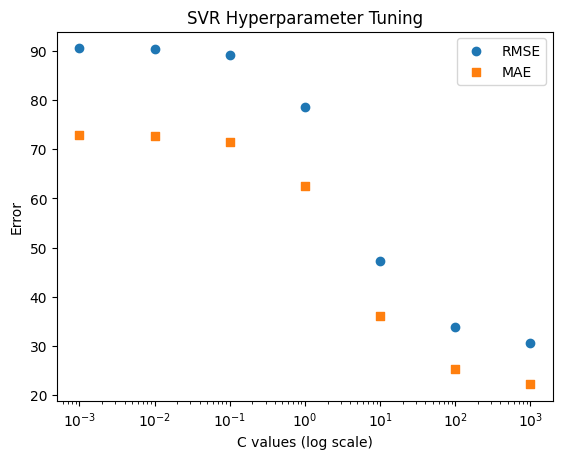

In [ ]:
# plot results
import matplotlib.pyplot as plt

plt.scatter(C_values, rmse_results, marker='o', label='RMSE')
plt.scatter(C_values, mae_results, marker='s', label='MAE')
plt.xscale('log')
plt.xlabel('C values (log scale)')
plt.ylabel('Error')
plt.title('SVR Hyperparameter Tuning')
plt.legend()
plt.show()

Now I will explore tuning the gamma parameter and plotting results

In [24]:
gamma_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

rmse_results_gamma = []
mae_results_gamma = []

for gamma in gamma_values:
    svr_model = SVR(gamma=gamma)
    rmse_val, mae_val = evaluate_model(svr_model, X_scaled, y)
    rmse_results_gamma.append(rmse_val)
    mae_results_gamma.append(mae_val)
    print(f"SVR with gamma={gamma} - RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")

SVR with gamma=0.001 - RMSE: 89.8166, MAE: 72.2529
SVR with gamma=0.01 - RMSE: 84.9490, MAE: 68.1630
SVR with gamma=0.1 - RMSE: 78.2156, MAE: 62.2703
SVR with gamma=1 - RMSE: 89.1025, MAE: 71.4217
SVR with gamma=10 - RMSE: 90.3591, MAE: 72.6697
SVR with gamma=100 - RMSE: 90.4886, MAE: 72.7955
SVR with gamma=1000 - RMSE: 90.5060, MAE: 72.8168


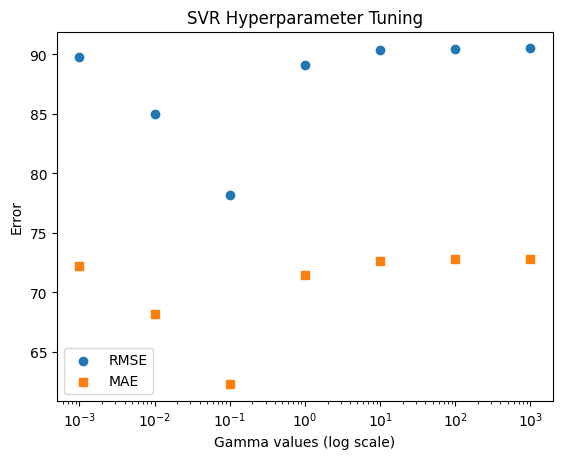

In [25]:
#plot results
plt.scatter(gamma_values, rmse_results_gamma, marker='o', label='RMSE')
plt.scatter(gamma_values, mae_results_gamma, marker='s', label='MAE')
plt.xscale('log')
plt.xlabel('Gamma values (log scale)')
plt.ylabel('Error')
plt.title('SVR Hyperparameter Tuning')
plt.legend()
plt.show()

Now I will tune both hyperparameters together and see which pairing is the strongest

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid_svr = GridSearchCV(SVR(), param_grid, scoring='neg_mean_squared_error', cv=10)
grid_svr.fit(X_scaled, y)

print(f"Best parameters: {grid_svr.best_params_}")
print(f"Best RMSE: {np.sqrt(-grid_svr.best_score_):.4f}")

Best parameters: {'C': 1000, 'gamma': 0.01}
Best RMSE: 43.7610


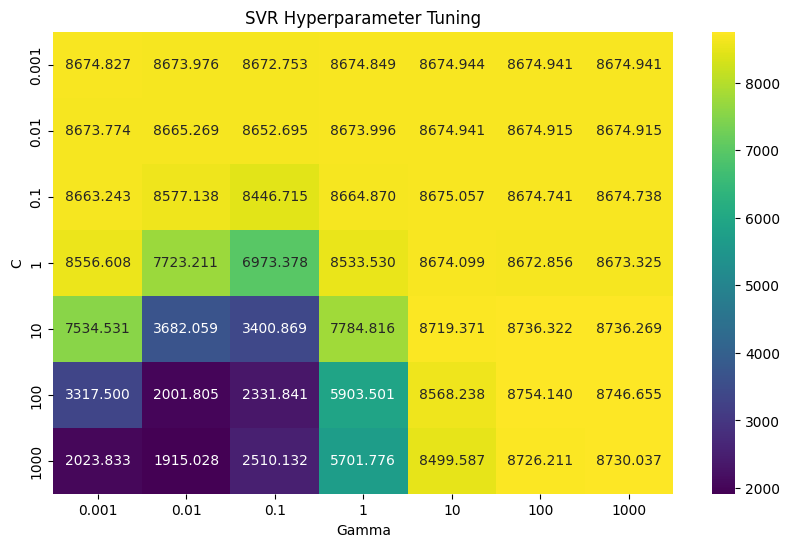

In [27]:
# create heatmap of results for rmse
import seaborn as sns
results = grid_svr.cv_results_
mean_test_scores = results['mean_test_score']
mean_test_scores = mean_test_scores.reshape(len(param_grid['C']), len(param_grid['gamma']))
plt.figure(figsize=(10, 6))
sns.heatmap(-mean_test_scores, annot=True, fmt=".3f", xticklabels=param_grid['gamma'], yticklabels=param_grid['C'], cmap="viridis")
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('SVR Hyperparameter Tuning')
plt.show()